In [75]:
import requests
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
from pymongo import MongoClient
import functions as fnc
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

In [94]:
coordinates = pd.read_csv('data/Barcelona_coordinates.csv') #File containing the coordinates we should used to get restaurants around them

In [13]:
load_dotenv()
MY_APY_KEY = os.getenv('API_KEY')

# Scrapping with Google Maps API

### 1. Extract all Restaurants in Barcelona

In [ ]:
radius = 50 #API can only return up to 60 restaurants per requests. That's why we need to iterate through eqaully spaced coordinates, and set a small radius

business_type = []
location = []
name = []
place_id = []
raiting = []
price_level = []
user_raitings_total = []
vicinity = []
total_req = 0

for j in coordinates.columns[:1]:
    for i in coordinates[j][:2]:
        response = fnc.norm_req(i, radius, MY_APY_KEY, total_req)
        fnc.appending_responses(response)
        try: #If I get >20 restaurants, I need to go to the following pages (API return up to 60 restaurants, ordered in 3 pages of 20 each)
            response =fnc.next_page_req(response, MY_APY_KEY, total_req)
            fnc.appending_responses(response)
            try: #If I further got more restaurants (>40 restaurants from the original request), I need to go to the third and last page
                response = fnc.next_page_req(response, MY_APY_KEY, total_req)
                fnc.appending_responses(response)
            except:
                pass
        except:
            pass
my_data = {
    'name': name,
    'place_id': place_id,
    'business_status': business_type,
    'location': location,
    'raiting': raiting,
    'price_level': price_level,
    'total_reviews': user_raitings_total,
    'direction': vicinity
}
my_data = pd.DataFrame(my_data)

my_data = my_data.drop_duplicates(subset=['place_id', 'location']) # Dropping same restaurant in case I scrapped twice
my_data['latitud'] = my_data['location'].apply(lambda x: x.split(",")[0].split(":")[1].strip()) #Isolating the latitud
my_data['longitud'] = my_data['location'].apply(lambda x: x.split(",")[1].split(":")[1].strip()[:-1]) #Isolating the longitud
my_data.drop(columns='location', inplace=True)

##### Getting the neightbourhood of each restaurant (using Mongo)

In [186]:
#I have previously created a database in Mongo which contains 11 documents (one for each district). Inside of them we have the properties and polygons
client = MongoClient("localhost:27017")
db = client["Search_Restaurants"]
df_distritos = db.get_collection("Distritos")

#Same as above but with neightbourhoods now.
client = MongoClient("localhost:27017")
db = client["Search_Restaurants"]
df_barrios = db.get_collection("Neightbours")

In [94]:
my_data['neightbour'] = my_data.apply(lambda row: fnc.get_barrios(df_barrios, row['longitud'], row['latitud']), axis=1)
my_data['distritos'] = my_data.apply(lambda row: fnc.get_barrios(df_distritos, row['longitud'], row['latitud']), axis=1)

In [197]:
my_data.to_csv('data/barc_restaurants.csv')

### 2. Extract reviews details

In [ ]:
restaurants = pd.read_csv('barc_restaurants.csv')
place_reviews = {'place_id':[], 'reviews': [], 'reviews_rating': [], 'time': []}

for i in restaurants['place_id']:
    url = f"https://maps.googleapis.com/maps/api/place/details/json?place_id={i}&fields=reviews&language=en&reviews_no_translations=false&key={MY_APY_KEY}"
    response = requests.request("GET", url, headers=headers, data=payload)
    try:
        for j in response.json()['result']['reviews']:
            place_reviews['place_id'].append(i)
            place_reviews['reviews'].append(j['text'])
            place_reviews['reviews_rating'].append(j['rating'])
            place_reviews['time'].append(j['time'])
    except KeyError:
        place_reviews['place_id'].append(i)
        place_reviews['reviews'].append('No reviews available')
        place_reviews['reviews_rating'].append(np.nan)
        place_reviews['time'].append(np.nan)

place_reviews = pd.DataFrame(place_reviews)
place_reviews.to_csv('data/restaurants_reviews.csv')

### 3. Extract URLs from restaurants

In [ ]:
restaurants = pd.read_csv('data/barc_restaurants.csv')
places_urls = {'place_id': [], 'url':[]}
for i in restaurants['place_id']:
    url = f"https://maps.googleapis.com/maps/api/place/details/json?place_id={i}&fields=url&key={MY_APY_KEY}"
    response = requests.request("GET", url, headers=headers, data=payload).json()
    places_urls['place_id'].append(i)
    try:
        places_urls['url'].append(response['result']['url'])
    except:
        places_urls['url'].append(np.nan)
to_write = pd.DataFrame(places_urls)
to_write.to_csv('data/restaurants_urls.csv')

### 4. Get restaurants extra details

In [ ]:
days = {
    '0': 'sun_hours'
    ,'1': 'mon_hours'
    ,'2': 'tue_hours'
    ,'3': 'wed_hours'
    ,'4': 'thu_hours'
    ,'5': 'fri_hours'
    ,'6': 'sat_hours'

}

restaurants = pd.read_csv('barc_restaurants.csv')
place_details = {'place_id':[], 'dine_in': [], 'reservable': [], 'serves_beer': [], 'serves_wine' :[], 'vegeterian': [], 'takeout': [], 'wheel_chair_acc': [], 
                 'mon_hours': [], 'tue_hours': [], 'wed_hours': [], 'thu_hours': [], 'fri_hours': [], 'sat_hours': [], 'sun_hours': []}

for i in restaurants['place_id']:
    url = f"https://maps.googleapis.com/maps/api/place/details/json?place_id={i}&fields=wheelchair_accessible_entrance%2Cdine_in%2Creservable%2Cserves_vegetarian_food%2Ctakeout%2Cserves_beer%2Cserves_wine%2Copening_hours&key={MY_APY_KEY}"
    response1 = requests.request("GET", url, headers=headers, data=payload)
    try:
        response = response1.json()['result']
        place_details['place_id'].append(i)
        try:
            place_details['dine_in'].append(response['dine_in'])
        except KeyError:
            place_details['dine_in'].append(np.nan)
        try:    
            place_details['reservable'].append(response['reservable'])
        except KeyError:
            place_details['reservable'].append(np.nan)
        try:
            place_details['serves_beer'].append(response['serves_beer'])
        except KeyError:
            place_details['serves_beer'].append(np.nan)
        try:
            place_details['serves_wine'].append(response['serves_wine'])
        except KeyError:
            place_details['serves_wine'].append(np.nan)
        try:
            place_details['vegeterian'].append(response['serves_vegetarian_food'])
        except KeyError:
            place_details['vegeterian'].append(np.nan)
        try:
            place_details['takeout'].append(response['takeout'])
        except KeyError:
            place_details['takeout'].append(np.nan)
        try:
            place_details['wheel_chair_acc'].append(response['wheelchair_accessible_entrance'])
        except KeyError:
            place_details['wheel_chair_acc'].append(np.nan)    
        count = 0
        try:
            a = response['opening_hours']['weekday_text']
            for j in response['opening_hours']['weekday_text']:
                place_details[days[str(count)]].append(j.split(": ", 1)[1].replace('\u202f', '').replace('\u2009', ''))
                count += 1
        except:
            for j in range(7):
                place_details[days[str(j)]].append(np.nan)
    except:
        pass

place_details = pd.DataFrame(place_details)

In [ ]:
place_details['dine_in'] = place_details['dine_in'].fillna('Maybe')
place_details['vegeterian'] = place_details['vegeterian'].fillna('Maybe')
place_details['wheel_chair_acc'] = place_details['wheel_chair_acc'].fillna('Maybe')
place_details['reservable'] = place_details['reservable'].fillna('Maybe')
place_details['serves_beer'] = place_details['serves_beer'].fillna('Maybe')
place_details['serves_wine'] = place_details['serves_wine'].fillna('Maybe')
place_details['takeout'] = place_details['takeout'].fillna('Maybe')

place_details['dine_in'].replace({'1.0': 'Yes', '0.0': 'No'}, inplace=True)
place_details['reservable'].replace({'1.0': 'Yes', '0.0': 'No'}, inplace=True)
place_details['serves_beer'].replace({'1.0': 'Yes', '0.0': 'No'}, inplace=True)
place_details['serves_wine'].replace({'1.0': 'Yes', '0.0': 'No'}, inplace=True)
place_details['vegeterian'].replace({'1.0': 'Yes', '0.0': 'No'}, inplace=True)
place_details['takeout'].replace({1.0: 'Yes', 0.0: 'No'}, inplace=True)
place_details['wheel_chair_acc'].replace({'1.0': 'Yes', '0.0': 'No'}, inplace=True)

place_details.to_csv('data/place_details.csv')

# Uploading data to SQL

In [2]:
df_restaurants = pd.read_csv('data/barc_restaurants.csv')
df_restaurants = df_restaurants.drop(columns=['index'])
df_restaurants.to_sql(con=fnc.create_connection('search_restaurants'), name='restaurants_details', if_exists='replace')

5023

In [3]:
df_reviews = pd.read_csv('data/restaurants_reviews.csv', encoding='latin1')
df_reviews = df_reviews.drop(columns=['Unnamed: 0', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7'])
df_reviews.to_sql(con=fnc.create_connection('search_restaurants'), name='restaurants_reviews', if_exists='replace')

24150

In [4]:
df_details = pd.read_csv('data/place_details.csv')
df_details = df_details.drop(columns=['index'])
df_details.to_sql(con=fnc.create_connection('search_restaurants'), name='restaurants_more_details', if_exists='replace')

5019

# Analysis

In [2]:
df_reviews = pd.read_sql_query("""
SELECT * FROM restaurants_reviews""", fnc.create_connection('search_restaurants'), index_col='index')
df_details = pd.read_sql_query("""
SELECT * FROM restaurants_details""", fnc.create_connection('search_restaurants'), index_col='index')
df_more_details = pd.read_sql_query("""
SELECT * FROM restaurants_more_details""", fnc.create_connection('search_restaurants'), index_col='index')

In [3]:
for i in df_more_details.columns[8:]:
    df_more_details[i] = df_more_details[i].apply(lambda x: fnc.converting_times_to_ranges(x))
df = df_details.merge(df_more_details, how='inner', on='place_id')
df = df[df['distritos'] != 'Not found']

In [4]:
df_reviews['adjectives'] = df_reviews['reviews'].apply(fnc.get_words)

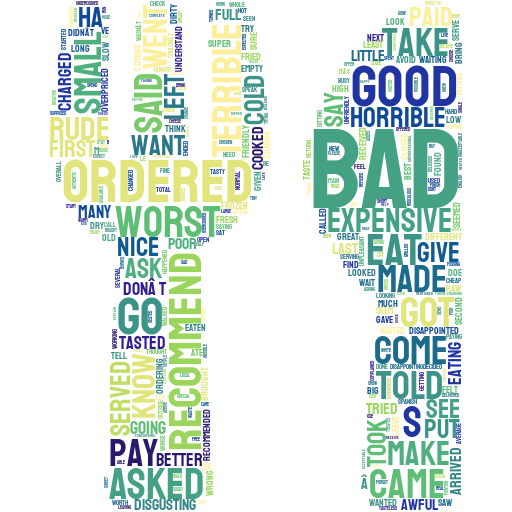

In [275]:
fnc.word_cloud(df_reviews, 1)

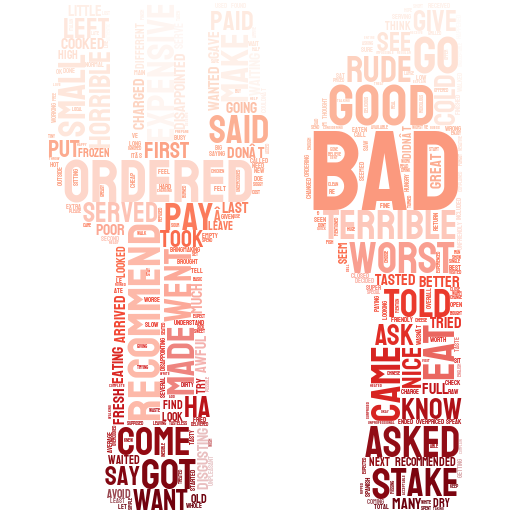

In [239]:
fnc.word_cloud(df_reviews, 1)

<Axes: xlabel='raiting', ylabel='total_reviews'>

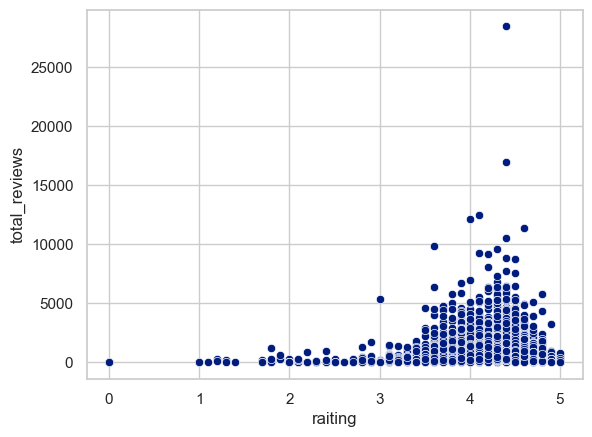

In [245]:
sns.scatterplot(x=df['raiting'], y=df['total_reviews'])

<Axes: xlabel='price_level', ylabel='raiting'>

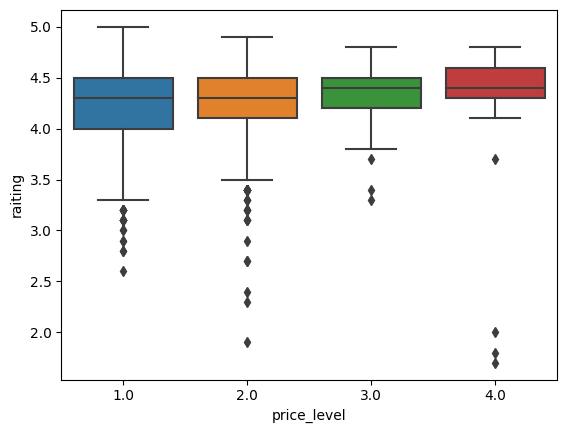

In [58]:
sns.boxplot(x=df['price_level'], y=df['raiting'])

In [204]:
def count_places_distr(df, rating):
   df = df[df['raiting'] >= rating]
   y = df.groupby(by='distritos')['place_id'].count().sort_values(ascending=False)
   sns.barplot(x=y.index, y=y.values, palette='blues')
   plt.xticks(rotation=90)
   plt.xlabel('Districts')
   plt.ylabel('Total Restaurants')
   plt.title('Total Restaurants by districts');

In [196]:
def count_places_barrios(df, district, rating):
   df = df[(df['raiting'] >= rating) & (df['distritos'] == district)]
   y = df.groupby(by='neightbour')['place_id'].count().sort_values(ascending=False)
   sns.barplot(x=y.index, y=y.values)
   plt.xticks(rotation=90)
   plt.xlabel('Neightbours')
   plt.ylabel('Total Restaurants')
   plt.title('Total Restaurants by neightbours');

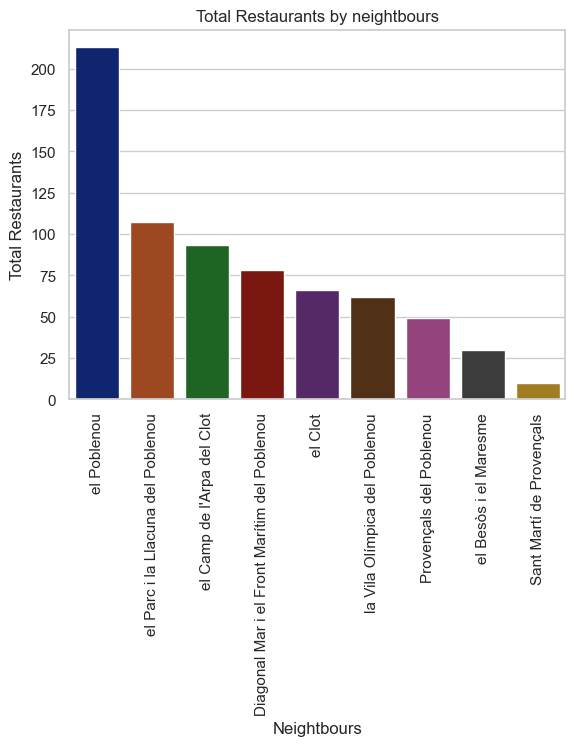

In [197]:
count_places_barrios(df, 'Sant Martí', 3)

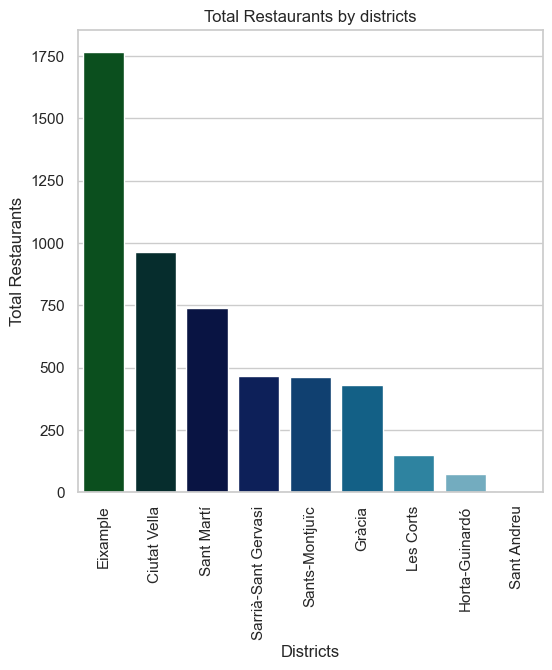

In [290]:
fig = plt.figure(figsize=(6,6))
order = df['distritos'].value_counts().index
sns.countplot(x=df['distritos'], order=order ,palette='ocean')
plt.xticks(rotation=90)
plt.xlabel('Districts')
plt.ylabel('Total Restaurants')
plt.title('Total Restaurants by districts')
fig.savefig('Figures/4. Total Restaurants by districts.png');

In [230]:
fig = plt.figure(figsize=(6,6))
order = df['distritos'].value_counts().index
sns.countplot(x=df['distritos'], order=order, hue=df[''])
plt.xticks(rotation=90)
plt.xlabel('Districts')
plt.ylabel('Total Restaurants')
plt.title('Total Restaurants by districts')
fig.savefig('Figures/4. Total Restaurants by districts.png');

array([5. , 4.9, 4.8, 4.7, 4.6, 4.5, 4.4, 4.3, 4.2, 4.1, 4. , 3.9, 3.8,
       3.7, 3.6, 3.5, 3.4, 3.3, 3.2, 3.1, 3. , 2.9, 2.8, 2.7, 2.6, 2.5,
       2.4, 2.3, 2.2, 2.1, 2. , 1.9, 1.8, 1.7, 1.4, 1.3, 1.2, 1.1, 1. ,
       0. ])

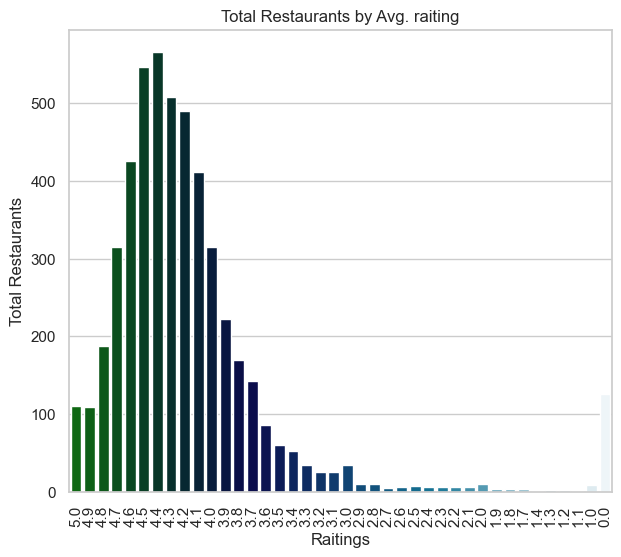

In [287]:
order = np.sort(df['raiting'].unique())[::-1]
fig = plt.figure(figsize=(7,6))
sns.countplot(x=df['raiting'], order = order, palette='ocean')
plt.xticks(rotation=90)
plt.xlabel('Raitings')
plt.ylabel('Total Restaurants')
plt.title('Total Restaurants by Avg. raiting')
fig.savefig('Figures/4. Total Restaurants by Avg. raiting.png');

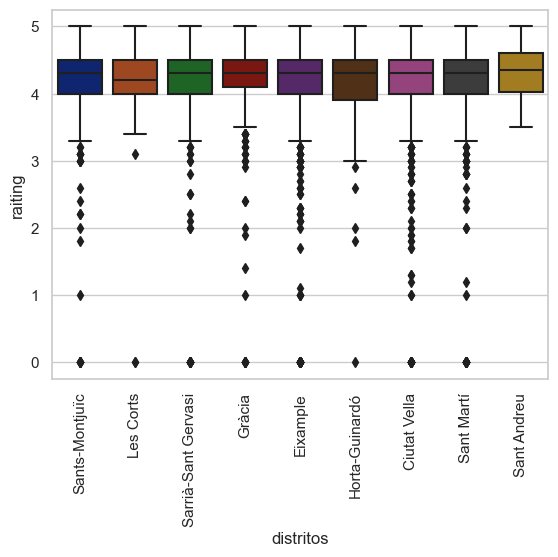

In [246]:
sns.boxplot(x=df['distritos'], y=df['raiting'])
plt.xticks(rotation=90);

In [84]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\augus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\augus\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\augus\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [94]:
df_reviews = df_reviews[df_reviews['reviews'].isna() == False]
df_reviews[['neg', 'neu', 'pos', 'compound']] = df_reviews['reviews'].apply(sid.polarity_scores).apply(pd.Series)
df_reviews

,place_id,reviews,reviews_rating,time,adjectives,neg,neu,pos,compound
index,,,,,,,,,
0,ChIJUwcqio-YpBIRranOacUHR2o,All was good. Nice food and and dessert. Quick...,5.0,1.546887e+09,"[good, Quick]",0.000,0.584,0.416,0.6908
1,ChIJUwcqio-YpBIRranOacUHR2o,Good Catalan Daily Menu.,5.0,1.566971e+09,[Good],0.000,0.508,0.492,0.4404
2,ChIJUwcqio-YpBIRranOacUHR2o,ie,5.0,1.545908e+09,[],0.000,1.000,0.000,0.0000
3,ChIJUwcqio-YpBIRranOacUHR2o,"We wanted to go for a long time, it is close t...",5.0,1.679325e+09,"[wanted, go, long, is, close, have, gone, try,...",0.000,0.754,0.246,0.8858
4,ChIJUwcqio-YpBIRranOacUHR2o,"Restaurant located next to the Plaza de Sants,...",3.0,1.685400e+09,"[located, next, good, daily, is, recommended, ...",0.027,0.758,0.215,0.9370
...,...,...,...,...,...,...,...,...,...
24145,ChIJAweFnpSipBIRBbwmnDuS5mA,"Lovely rooftop bar, the food was lovely and th...",4.0,1.687027e+09,"[rooftop, were, friendly, considering, didnâ...",0.031,0.790,0.179,0.9247
24146,ChIJAweFnpSipBIRBbwmnDuS5mA,"Best meal in Barcelona! Ambiance, foodie choic...",5.0,1.681672e+09,"[Best, foodie, amazing, is, total, memorable, ...",0.000,0.657,0.343,0.9097
24147,ChIJAweFnpSipBIRBbwmnDuS5mA,Amazing! The view is incredible. the food is v...,5.0,1.685109e+09,"[is, incredible, tasty]",0.000,0.579,0.421,0.8058


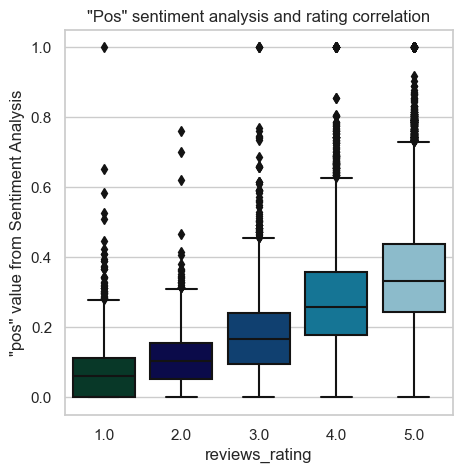

In [281]:
fig = plt.figure(figsize=(5,5))
sns.boxplot(x=df_reviews['reviews_rating'], y=df_reviews['pos'], palette='ocean')
plt.ylabel('"pos" value from Sentiment Analysis')
plt.title('"Pos" sentiment analysis and rating correlation')
fig.savefig('Figures/5. Pos sentiment analysis and rating correlation.png');

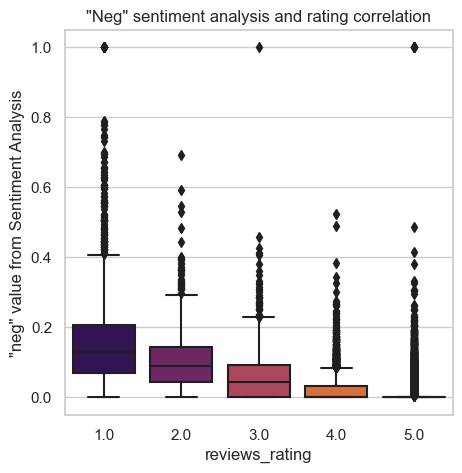

In [282]:
fig = plt.figure(figsize=(5,5))
sns.boxplot(x=df_reviews['reviews_rating'], y=df_reviews['neg'], palette='inferno')
plt.ylabel('"neg" value from Sentiment Analysis')
plt.title('"Neg" sentiment analysis and rating correlation')
fig.savefig('Figures/6. Neg sentiment analysis and rating correlation.png');

In [101]:
outliers = df_reviews[(df_reviews['neg'] > 0.4) &(df_reviews['reviews_rating'] >= 4)]
outliers

,place_id,reviews,reviews_rating,time,adjectives,neg,neu,pos,compound
index,,,,,,,,,
1131,ChIJ9zg6vwKZpBIRcIX3s9-yE6A,Brutal!,5.0,1.684473e+09,[],1.000,0.000,0.000,-0.6588
2614,ChIJGbzMK-ijpBIRMBSjSbKxlVs,Missing English menus.,4.0,1.578501e+09,"[Missing, English]",0.524,0.476,0.000,-0.2960
2957,ChIJzRB9WUuZpBIRhnVf7DD7LpE,Brutal,5.0,1.686346e+09,[],1.000,0.000,0.000,-0.6249
3842,ChIJDQKu8YCipBIRAx4FUfd2xd8,Brutal,5.0,1.686324e+09,[],1.000,0.000,0.000,-0.6249
4431,ChIJJ3rp8YaipBIRbb9b5c_Z6AU,Raul good Gali bad,5.0,1.557531e+09,"[good, bad]",0.417,0.238,0.345,-0.1531
5038,ChIJ3668k32ipBIR_GDHsUDBde4,Brutal,5.0,1.681905e+09,[],1.000,0.000,0.000,-0.6249
7995,ChIJuxezLF25Z0ARnEy3Hz3TVig,Brutal!!,5.0,1.635519e+09,[],1.000,0.000,0.000,-0.6892
21120,ChIJJ5bFCNijpBIRBrtcjO9ifIg,Brutal!,5.0,1.602503e+09,[],1.000,0.000,0.000,-0.6588
21337,ChIJb5jvVj6jpBIRIEqQbyEEP8E,I miss this place!,5.0,1.428094e+09,[miss],0.486,0.514,0.000,-0.2244


In [103]:
outliers = df_reviews[(df_reviews['pos'] > 0.5) & (df_reviews['reviews_rating'] <= 2)]
outliers

,place_id,reviews,reviews_rating,time,adjectives,neg,neu,pos,compound
index,,,,,,,,,
715,ChIJMTYqA2-YpBIRbc9zIA2sY68,Very good food. Great lobster rice.,1.0,1.680207e+09,[good],0.000,0.346,0.654,0.8204
2919,ChIJbxhVNKCZpBIRqBzUIK0pMSs,pretty mid,2.0,1.674130e+09,[],0.000,0.238,0.762,0.4939
7428,ChIJVVUJKZaipBIRrcB7kh-CPxo,"Wow, disgusting.",1.0,1.590347e+09,[disgusting],0.472,0.000,0.528,0.1027
11026,ChIJ1V3TfeejpBIRqrA-zdbHrc8,"disgusting food but, waiter alex is very nice :)",1.0,1.642875e+09,"[disgusting, waiter, is, nice]",0.131,0.358,0.511,0.8104
11185,ChIJlUR0dF-ipBIRCqX0YytlIRQ,Precious,1.0,1.514378e+09,[Precious],0.000,0.000,1.000,0.5719
12456,ChIJY1Hao8WipBIRxhPHqd3RuDY,Scammer i love mal educat,1.0,1.677870e+09,"[love, mal]",0.000,0.417,0.583,0.6369
20397,ChIJy6PRyRGjpBIRtWu86bmdTsQ,A joke. Service a joke.\nFood an even bigger j...,2.0,1.686911e+09,"[bigger, round, hilarious]",0.000,0.378,0.622,0.8591
20735,ChIJx-Ysfz6jpBIRYVrh8NEpi4U,Good site and great quality,2.0,1.675933e+09,"[Good, great]",0.000,0.300,0.700,0.7906
